# Imports

In [1]:
from orbit_generation.visualize import visualize_static_orbits
from orbit_generation.constants import EM_MU
from orbit_generation.convergence import process_diferential_correction_orbits
from orbit_generation.stats import plot_histograms_comparison, plot_histograms_position
from orbit_generation.processing import reorder_orbits, interpolate_equal_times, downsample_3d_array


In [2]:
import numpy as np
import os
import pandas as pd
from itertools import product
import re

# Data

In [3]:
data_path = r"/orbit-generation/data/orbits_fix_1500/EM_N_fix_1500.h5"
experiments_folder = r'../experiments'

In [4]:
def concatenate_orbits_from_experiment_folder(experiments_folder, seq_len):
    arrays = []
    
    for folder in os.listdir(experiments_folder):
        if folder.startswith('experiment_') and os.path.isdir(os.path.join(experiments_folder, folder)):
            # Extract the experiment number using regex
            match = re.search(r'experiment_(\d+)', folder)
            if match:
                experiment_id = match.group(1)
                generated_data_path = os.path.join(experiments_folder, folder, f'exp{experiment_id}_generated_orbits.npy')
                
                if os.path.isfile(generated_data_path):
                    generated_orbit = np.load(generated_data_path)
                    
                    if generated_orbit.shape[-1] == seq_len:
                        arrays.append(generated_orbit)
    
    if arrays:
        return np.concatenate(arrays, axis=0)
    else:
        return np.array([])

In [5]:
generation = concatenate_orbits_from_experiment_folder(experiments_folder, 100)
generation.shape

(1100, 7, 100)

## Visualize

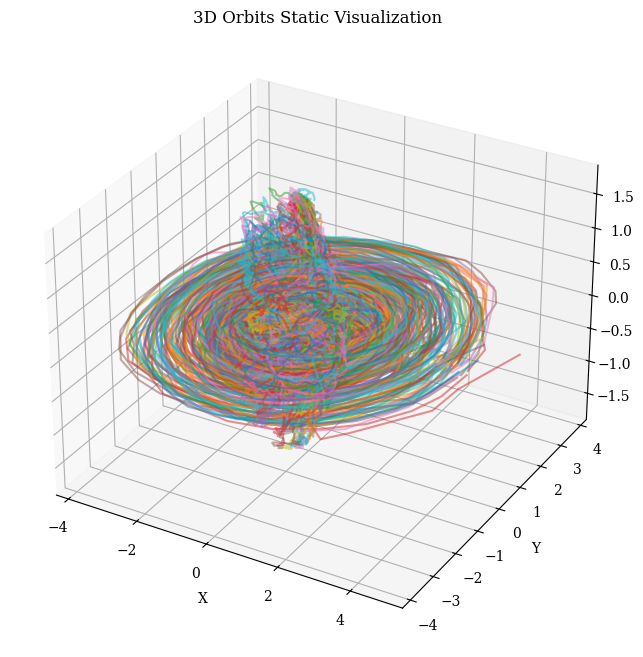

In [6]:
visualize_static_orbits(generation[:,1:,:], show_legend=False)

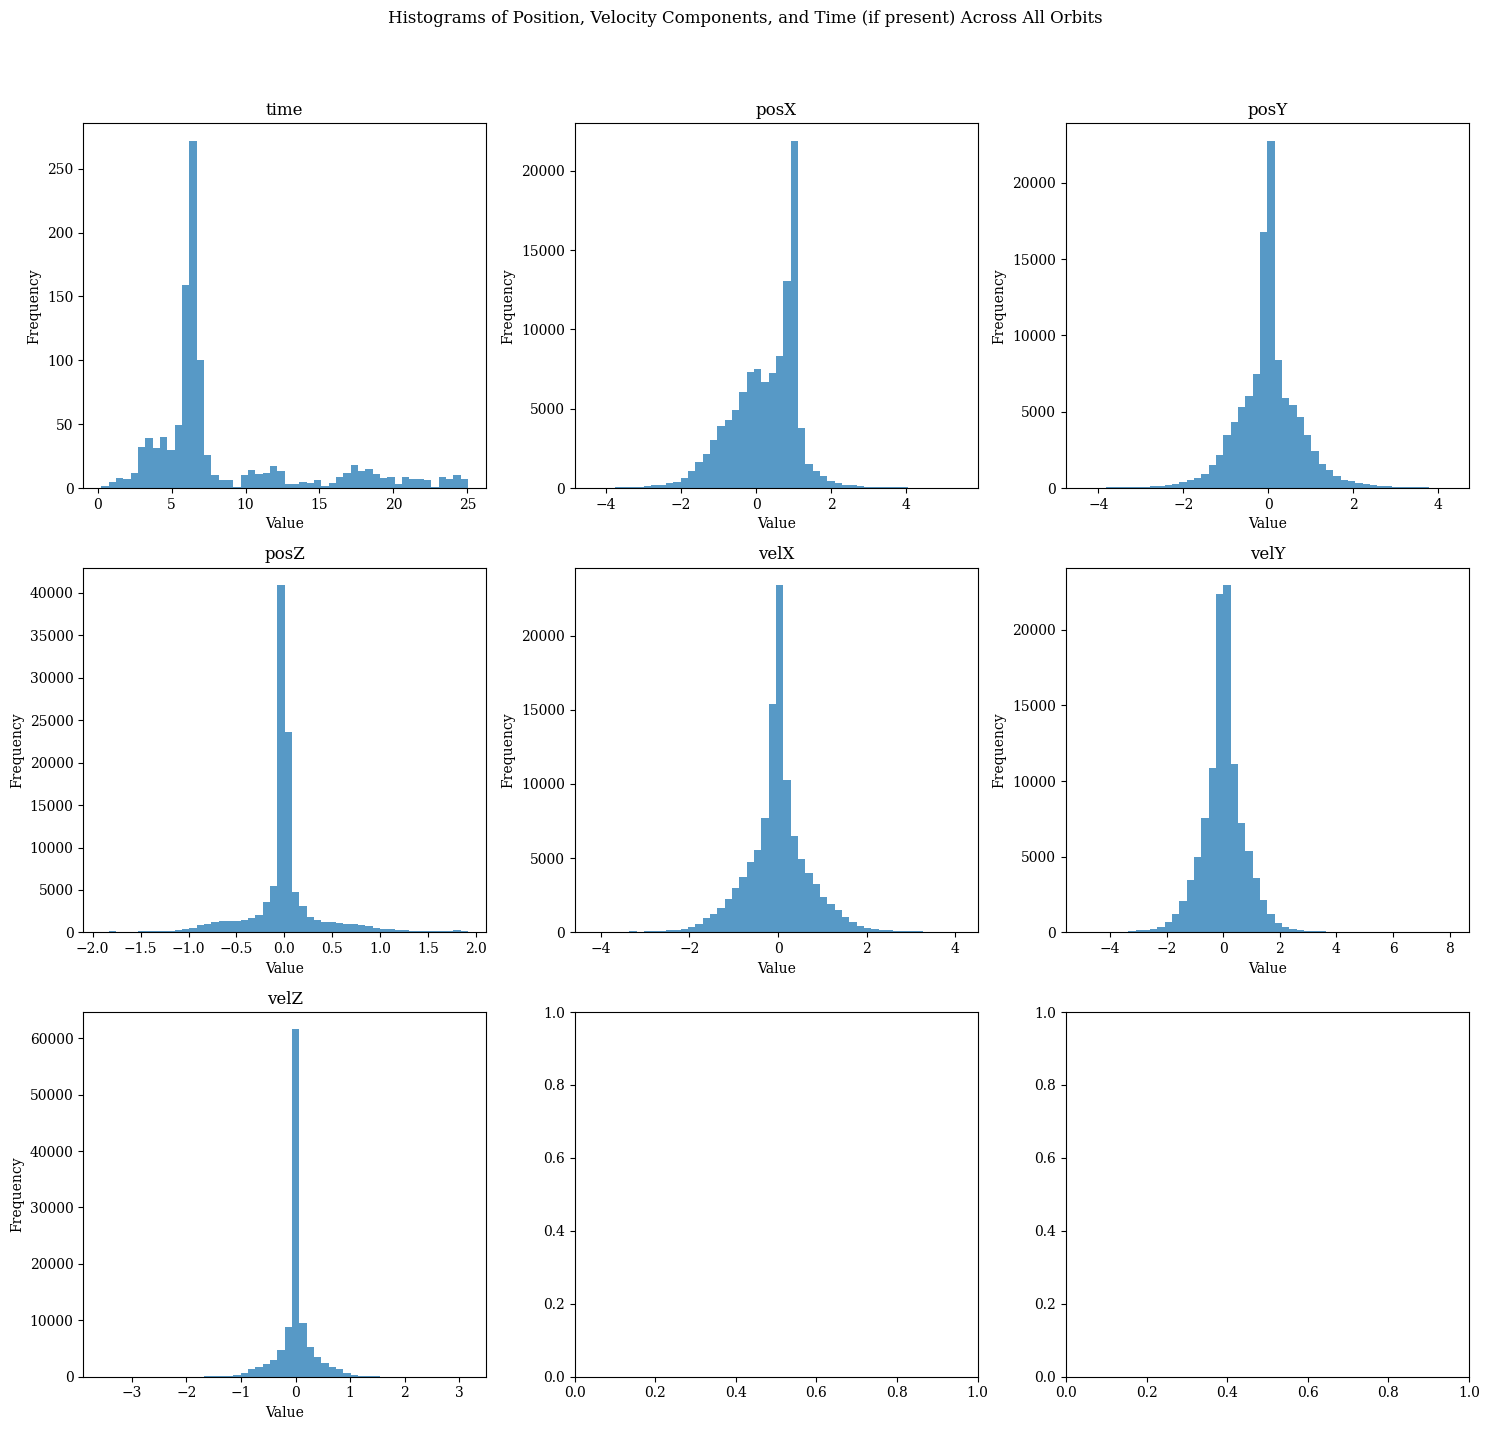

In [7]:
plot_histograms_position(generation)

## Process

In [8]:
#Order metrics
reordered_generation, order_metrics_array, order_metric_labels = reorder_orbits(generation)
generation_df = pd.DataFrame(order_metrics_array, columns=order_metric_labels)
generation_df.head()

,disorder_metric,correct_order,inversions,kendall_tau_distance
0,164.0,71.0,105.0,0.042424
1,74.0,82.0,44.0,0.017778
2,96.0,77.0,62.0,0.025051
3,138.0,79.0,90.0,0.036364
4,184.0,71.0,125.0,0.050505


In [9]:
interpolated_generation = interpolate_equal_times(reordered_generation)
interpolated_generation.shape

(1100, 7, 100)

# Convergence


In [ ]:
def convergence_experiment(parameter_set, orbits, gravitational_constant, base_filename):
    def generate_identifier(params):
        return f"max_iter_{params['max_iter_convergence']}_seq_len_{params['input_seq_len_convergence']}"

    identifier = generate_identifier(parameter_set)

    # Extract the directory and base name from base_filename
    output_dir = os.path.dirname(base_filename)
    base_name = os.path.splitext(os.path.basename(base_filename))[0]

    if parameter_set['input_seq_len_convergence'] == 1:
        downsampled_orbits = orbits
    else:
        downsampled_orbits = downsample_3d_array(orbits, axis=2, hop=int(1/parameter_set['input_seq_len_convergence']))
    print(f"Downsampled orbits shape: {downsampled_orbits.shape}")
    
    # Process differential correction orbits
    refined_orbits, refined_orbits_df = process_diferential_correction_orbits(
        np.transpose(orbits, (0, 2, 1)),
        gravitational_constant,
        max_iter=parameter_set['max_iter_convergence']
    )
    
    # Transpose refined orbits
    refined_orbits = np.transpose(refined_orbits, (0, 2, 1))
    
    # Add parameter information to the DataFrame
    refined_orbits_df['max_iter_convergence'] = parameter_set['max_iter_convergence']
    refined_orbits_df['input_seq_len_convergence'] = parameter_set['input_seq_len_convergence']
    
    # Save DataFrame
    df_filename = os.path.join(output_dir, f"{base_name}_df_{identifier}.csv")
    refined_orbits_df.to_csv(df_filename, index=False)
    print(f"Saved DataFrame to {df_filename}")
    
    # Save array
    array_filename = os.path.join(output_dir, f"{base_name}_array_{identifier}.npy")
    np.save(array_filename, refined_orbits)
    print(f"Saved array to {array_filename}")
    
    # Plotting functions
    histogram_save_path = os.path.join(output_dir, f"{base_name}_histogram_{identifier}.png")
    plot_histograms_comparison(data1=orbits, data2=refined_orbits, label1='Generation', label2='Refinement', normalize=True, save_path=histogram_save_path)
    print(f"Saved histogram to {histogram_save_path}")

    orbits_save_path = os.path.join(output_dir, f"{base_name}_orbits_{identifier}.png")
    visualize_static_orbits(refined_orbits[:,1:,:], show_legend=False, save_path=orbits_save_path)
    print(f"Saved orbit visualization to {orbits_save_path}")
    
    return refined_orbits, refined_orbits_df

In [ ]:
experiment_folder = '../experiments/convergence_experiment/conver_exp'

In [10]:
params = {
    # Convergence
    'max_iter_convergence': [20, 50],
    'input_seq_len_convergence': [0.1, 0.5, 1]
}

In [11]:
parameter_sets = [
    dict(zip(params.keys(), values))
    for values in product(*params.values())
]

parameter_sets

[{'max_iter_convergence': 20, 'input_seq_len_convergence': 0.1},
 {'max_iter_convergence': 20, 'input_seq_len_convergence': 0.5},
 {'max_iter_convergence': 20, 'input_seq_len_convergence': 1},
 {'max_iter_convergence': 50, 'input_seq_len_convergence': 0.1},
 {'max_iter_convergence': 50, 'input_seq_len_convergence': 0.5},
 {'max_iter_convergence': 50, 'input_seq_len_convergence': 1}]

In [ ]:
refined_orbits, refined_orbits_df = convergence_experiment(parameter_sets[0], interpolated_generation, EM_MU, experiment_folder)

In [ ]:
refined_orbits, refined_orbits_df = convergence_experiment(parameter_sets[1], interpolated_generation, EM_MU, experiment_folder)

In [ ]:
refined_orbits, refined_orbits_df = convergence_experiment(parameter_sets[2], interpolated_generation, EM_MU, experiment_folder)

In [ ]:
refined_orbits, refined_orbits_df = convergence_experiment(parameter_sets[3], interpolated_generation, EM_MU, experiment_folder)

In [ ]:
refined_orbits, refined_orbits_df = convergence_experiment(parameter_sets[4], interpolated_generation, EM_MU, experiment_folder)

In [ ]:
refined_orbits, refined_orbits_df = convergence_experiment(parameter_sets[5], interpolated_generation, EM_MU, experiment_folder)

# Analysis

In [ ]:
import os
import glob
import pandas as pd
import numpy as np

def read_and_concatenate_results(experiment_folder):
    # Initialize empty lists to store DataFrames and orbits
    all_dfs = []
    all_orbits = []

    # Pattern for CSV files
    csv_pattern = os.path.join(experiment_folder, '*_df_*.csv')
    
    # Pattern for numpy array files
    npy_pattern = os.path.join(experiment_folder, '*_array_*.npy')

    # Read all CSV files
    for csv_file in glob.glob(csv_pattern):
        df = pd.read_csv(csv_file)
        all_dfs.append(df)

    # Read all numpy array files
    for npy_file in glob.glob(npy_pattern):
        orbits = np.load(npy_file)
        all_orbits.append(orbits)

    # Concatenate all DataFrames
    combined_df = pd.concat(all_dfs, ignore_index=True)

    return combined_df, all_orbits

In [ ]:
combined_refined_orbits_df, all_refined_orbits = read_and_concatenate_results(experiment_folder)

In [ ]:
len(all_refined_orbits)

In [ ]:
combined_refined_orbits_df.shape